In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8


In [66]:
dataset_renaming = {
    "mendelian_traits_matched_9": "Mendelian traits",
    "complex_traits_matched_9": "Complex traits",
}

subset_renaming = {
    #"disease": "Complex traits\n" + r"$\mathbf{(disease)}$",
    #"non_disease": "Complex traits\n" + r"$\mathbf{(non}$" + "-" + r"$\mathbf{disease)}$",
    "disease": "Disease",
    "non_disease": "Non-disease",
}

In [67]:
datasets = [
    "complex_traits_matched_9",
]

subsets = [
    "disease",
    "non_disease",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "Borzoi",
    "GPN-MSA",
    "CADD",
    "CADD+GPN-MSA+Borzoi",
]

def get_model_path(model, modality, dataset, subset):
    if modality == "Linear probing":
        predictor = f"{model}.LogisticRegression.chrom.subset_from_all"
    elif modality == "Zero-shot":
        if model == "CADD":
            predictor = "CADD.plus.RawScore"
        elif model in ["Enformer", "Borzoi"]:
            predictor = f"{model}_L2_L2.plus.all"
        else:
            if "mendelian" in dataset:
                llr_version = "LLR"
                sign = "minus"
            elif "complex" in dataset:
                llr_version = "absLLR"
                sign = "plus"
            predictor = f"{model}_{llr_version}.{sign}.score"
    return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"

In [68]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if modality == "Zero-shot" and "+" in model: continue
                model_for_path = model
                if "mendelian" in dataset and model == "CADD+GPN-MSA+Borzoi":
                    model_for_path = "CADD+GPN-MSA_LLR+Borzoi_L2_L2"
                path = get_model_path(
                    model_for_path,
                    modality,
                    dataset,
                    subset
                )
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model_renaming.get(model, model),
                    df["score"],
                    df["se"],
                ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,Complex traits,Disease,Zero-shot,Borzoi,0.325836,0.061967
1,Complex traits,Disease,Zero-shot,GPN-MSA,0.359851,0.047435
2,Complex traits,Disease,Zero-shot,CADD,0.359607,0.047292
3,Complex traits,Disease,Linear probing,Borzoi,0.356182,0.048548
4,Complex traits,Disease,Linear probing,GPN-MSA,0.358350,0.051685
5,Complex traits,Disease,Linear probing,CADD,0.368307,0.048352
6,Complex traits,Disease,Linear probing,Ensemble,0.411178,0.052781
7,Complex traits,Non-disease,Zero-shot,Borzoi,0.237848,0.009305
8,Complex traits,Non-disease,Zero-shot,GPN-MSA,0.224387,0.009717
9,Complex traits,Non-disease,Zero-shot,CADD,0.250922,0.009986


In [69]:
def best_modality(df):
    res = df.sort_values("score", ascending=False).iloc[0]
    return res[["score", "se"]]

df = df.groupby(["dataset", "subset", "model"], sort=False).apply(best_modality).reset_index()
df

,dataset,subset,model,score,se
0,Complex traits,Disease,Borzoi,0.356182,0.048548
1,Complex traits,Disease,GPN-MSA,0.359851,0.047435
2,Complex traits,Disease,CADD,0.368307,0.048352
3,Complex traits,Disease,Ensemble,0.411178,0.052781
4,Complex traits,Non-disease,Borzoi,0.299345,0.014262
5,Complex traits,Non-disease,GPN-MSA,0.270236,0.011233
6,Complex traits,Non-disease,CADD,0.285647,0.012329
7,Complex traits,Non-disease,Ensemble,0.364814,0.015568


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

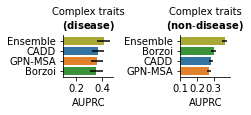

In [46]:
g = sns.FacetGrid(
    data=df.rename(columns={"score": "AUPRC"}),
    col="subset",
    #margin_titles=True,
    #sharex="col",
    sharex=False,
    sharey=False,
    height=1.7,
    #aspect=1.8,
)

def my_boxplot(data, **kwargs):
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    bar_height = g.patches[0].get_height()
    y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
    ax.errorbar(
        x=data["AUPRC"],
        y=y_coords,
        xerr=data["se"],
        fmt='none',
        color="black",
    )

g.map_dataframe(my_boxplot)
g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(
    col_template="{col_name}", row_template="{row_name}",
    #fontweight="bold",
    #size=12,
)
g.tight_layout()
#plt.savefig("../../results/plots/performance_disease.pdf", bbox_inches="tight")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

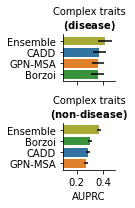

In [47]:
g = sns.FacetGrid(
    data=df.rename(columns={"score": "AUPRC"}),
    row="subset",
    #margin_titles=True,
    #sharex="col",
    sharex=True,
    sharey=False,
    height=1.5,
    aspect=1.2,
)

def my_boxplot(data, **kwargs):
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    bar_height = g.patches[0].get_height()
    y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
    ax.errorbar(
        x=data["AUPRC"],
        y=y_coords,
        xerr=data["se"],
        fmt='none',
        color="black",
    )

g.map_dataframe(my_boxplot)
g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(
    col_template="{col_name}", row_template="{row_name}",
    #fontweight="bold",
    #size=12,
)
g.tight_layout()
plt.savefig("../../results/plots/performance_disease.pdf", bbox_inches="tight")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

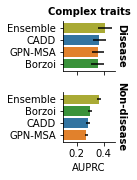

In [72]:
g = sns.FacetGrid(
    data=df.rename(columns={"score": "AUPRC"}),
    col="dataset",
    row="subset",
    margin_titles=True,
    #sharex="col",
    sharex=True,
    sharey=False,
    height=1.3,
    aspect=1.5,
)

def my_boxplot(data, **kwargs):
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    bar_height = g.patches[0].get_height()
    y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
    ax.errorbar(
        x=data["AUPRC"],
        y=y_coords,
        xerr=data["se"],
        fmt='none',
        color="black",
    )

g.map_dataframe(my_boxplot)
g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(
    col_template="{col_name}", row_template="{row_name}",
    fontweight="bold",
    #size=12,
)
g.tight_layout()
plt.savefig("../../results/plots/performance_disease.pdf", bbox_inches="tight")